# Q4 (1) - Yield Curve

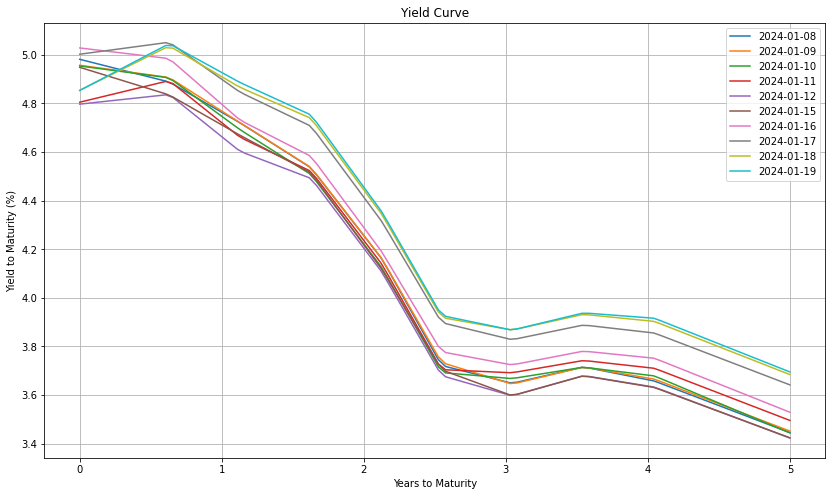

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from datetime import datetime, timedelta
from scipy.interpolate import interp1d

# Calculate the upcoming coupon dates
def upcoming_coupon_dates(start_date, end_date, include_all=False):
    next_coupons = []
    while end_date > start_date:
        next_coupons.insert(0, end_date)
        month = (end_date.month - 6) % 12
        year = end_date.year - (1 if month > end_date.month else 0)
        end_date = end_date.replace(year=year, month=month or 12)
    
    return next_coupons if include_all else next_coupons[0]

# Convert dates to year fractions
def years_between(d1, d2):
    return (d2 - d1).days / 365

# Calculate the Yield to Maturity
def calculate_ytm(market_price, annual_coupon, par_value, cashflows, year_fractions):
    initial_guess = annual_coupon
    cashflow_array = np.array(cashflows)
    year_fraction_array = np.array(year_fractions)

    def ytm_function(rate):
        discount_factors = np.exp(-rate * year_fraction_array)
        present_value = np.sum(cashflow_array * discount_factors)
        return present_value - market_price

    ytm_result = fsolve(ytm_function, initial_guess)
    return ytm_result[0]

# Compute YTM considering the list of coupon dates
def compute_ytm(start_date, end_date, market_price, annual_coupon, par_value):
    coupon_schedule = upcoming_coupon_dates(start_date, end_date, include_all=True)
    year_fractions = [years_between(start_date, coupon_date) for coupon_date in coupon_schedule]
    cashflows = [annual_coupon * par_value / 2 for _ in coupon_schedule]
    cashflows[-1] += par_value
    computed_ytm = calculate_ytm(market_price, annual_coupon, par_value, cashflows, year_fractions)
    return computed_ytm

# Load the datasets
bond_data = pd.read_csv('bond_info.csv')
price_data = pd.read_csv('bond_price.csv')


bond_data['BondName'] = bond_data['NAME'].str.strip()
bond_data['CouponRate'] = bond_data['COUPON'].str.rstrip('%').astype(float) / 100
bond_data['IssueDate'] = pd.to_datetime(bond_data['ISSUE DATE'])
bond_data['MaturityDate'] = pd.to_datetime(bond_data['MATURITY DATE'])

# Adjust 'price_data' headers to datetime and ensure alignment with 'bond_data'
price_data.columns = [col if idx == 0 else pd.to_datetime(col, format='%d-%b-%y') for idx, col in enumerate(price_data.columns)]

# Initialize a dataframe for YTM
yield_to_maturity_results = pd.DataFrame()

# Calculate YTM for each bond at each date
for date_col in price_data.columns[1:]:
    yield_to_maturity_results[date_col.strftime('%Y-%m-%d') + '_YTM'] = np.nan
    for idx, bond_row in bond_data.iterrows():
        trade_price = price_data.at[idx, date_col]
        coupon = bond_row['CouponRate']
        face_value = 100
        current_date = date_col
        maturity = bond_row['MaturityDate']
        if trade_price and maturity > current_date:
            yield_result = compute_ytm(current_date, maturity, trade_price, coupon, face_value)
            yield_to_maturity_results.at[idx, date_col.strftime('%Y-%m-%d') + '_YTM'] = yield_result

# Combine the YTM results with 'bond_data'
combined_data = pd.concat([bond_data, yield_to_maturity_results], axis=1)

# Plot
plt.figure(figsize=(14, 8))

if 'YearsToMaturity' not in combined_data:
    combined_data['YearsToMaturity'] = (combined_data['MaturityDate'] - datetime.now()).dt.days / 365


curve_maturities = np.linspace(0, 5, num=100)
yield_curve_data = pd.DataFrame(index=curve_maturities)

for ytm_column in yield_to_maturity_results.columns:
    valid_maturities = combined_data['YearsToMaturity']
    valid_yields = yield_to_maturity_results[ytm_column].dropna()*100
    
    # Ensure there are at least two points to plot
    if len(valid_yields) >= 2:
        # Create linear interpolation for the yield curve
        ytm_curve = interp1d(valid_maturities[valid_yields.index], valid_yields, kind='linear', fill_value='extrapolate')
        
        # Apply the interpolation function to the maturity range
        interpolated_yields = ytm_curve(curve_maturities)
        
        plt.plot(curve_maturities, interpolated_yields, label=ytm_column.split('_')[0])
        yield_curve_data[ytm_column.split('_')[0]] = interpolated_yields
        

plt.title('Yield Curve')
plt.xlabel('Years to Maturity')
plt.ylabel('Yield to Maturity (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Yield curve data

In [13]:
print(yield_curve_data)

          2024-01-08  2024-01-09  2024-01-10  2024-01-11  2024-01-12  \
0.000000    4.981686    4.957188    4.954246    4.805129    4.797183   
0.050505    4.974200    4.953142    4.950329    4.812258    4.800368   
0.101010    4.966713    4.949096    4.946413    4.819387    4.803553   
0.151515    4.959227    4.945050    4.942497    4.826516    4.806739   
0.202020    4.951740    4.941003    4.938581    4.833645    4.809924   
...              ...         ...         ...         ...         ...   
4.797980    3.490379    3.496880    3.493764    3.540949    3.467452   
4.848485    3.479142    3.485557    3.481343    3.529587    3.456358   
4.898990    3.467905    3.474234    3.468921    3.518225    3.445263   
4.949495    3.456668    3.462911    3.456499    3.506863    3.434169   
5.000000    3.445431    3.451588    3.444077    3.495501    3.423074   

          2024-01-15  2024-01-16  2024-01-17  2024-01-18  2024-01-19  
0.000000    4.948792    5.028421    5.002607    4.854041    4.85

# Q4 (2) - Spot Rate


<ipython-input-7-491dda214767>:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  discount_factors_array = np.array(discount_factors, dtype=np.float64)


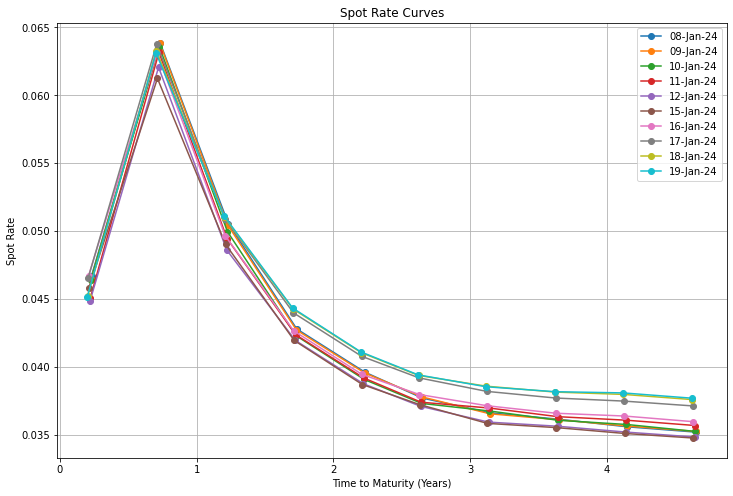

In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from datetime import datetime
import matplotlib.pyplot as plt

# Load the bond data
filename = 'bond.csv'
bonds = pd.read_csv(filename)

# Set the current date
current_date = datetime(2024, 1, 8)

# Calculate the present value of cash flows
def present_value(cash_flows, discount_factors):
    cash_flows_array = np.array(cash_flows, dtype=np.float64)
    discount_factors_array = np.array(discount_factors, dtype=np.float64)
    return np.sum(cash_flows_array * discount_factors_array)


# Bootstrapping 
def bootstrap(bonds,price_date, current_date):
    spot_rates = {}
    for _, bond in bonds.iterrows():
        maturity_date = datetime.strptime(bond['MATURITY DATE'], '%d-%b-%y')
        ttm = (maturity_date - current_date).days / 365.0  # Time to maturity in years

        if ttm < 0.5:
            # Bonds maturing in less than 0.5 years
            cash_flows = [(bond['COUPON'] * 100 * ttm) + 100]
            times = [ttm]
            discount_factors = [np.exp(-bond['YIELD'] * ttm)]

        else:
            cash_flows = [bond['COUPON'] / 2 * 100] * int(ttm / 0.5)
            cash_flows[-1] += 100  # Add the face value to the last cash flow
            times = np.arange(0.5, ttm + 0.1, 0.5)

        # Discount factors
        discount_factors = [np.exp(-spot_rates.get(time, 0) * time) for time in times]

        # Determine the spot rate for the bond
        def objective(spot_rate):
            discount_factors[-1] = np.exp(-spot_rate * times[-1])
            pv = present_value(cash_flows, discount_factors)
            return pv - bond[price_date]

        # Solve for the spot rate
        spot_rate = fsolve(objective, bond['YIELD'])[0]
        spot_rates[ttm] = spot_rate

    return spot_rates


plt.figure(figsize=(12, 8))
plt.title('Spot Rate Curves')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Rate')
plt.grid(True)

# Loop through each price date column to calculate and plot the spot rate curve
price_columns = bonds.columns[bonds.columns.get_loc('08-Jan-24'):]
for price_date in price_columns:
    current_date = datetime.strptime(price_date, '%d-%b-%y')
    spot_rates = bootstrap(bonds, price_date, current_date)
    sorted_terms = sorted(spot_rates.keys())
    sorted_rates = [spot_rates[term] for term in sorted_terms]
    plt.plot(sorted_terms, sorted_rates, marker='o', label=price_date)


plt.legend()
plt.show()

## Spot rate data

In [9]:
def extract_spot_rates_for_all_dates(bonds, price_columns):
    # Hold spot rates
    all_spot_rates = {}

    for price_date in price_columns:
        current_date = datetime.strptime(price_date, '%d-%b-%y')
        spot_rates = bootstrap(bonds, price_date, current_date)
        all_spot_rates[current_date] = spot_rates
    return all_spot_rates

# Extract the spot rates for all dates using the function
price_columns = bonds.columns[bonds.columns.get_loc('08-Jan-24'):]
spot_rates_by_date = extract_spot_rates_for_all_dates(bonds, price_columns)

print(spot_rates_by_date)  

{datetime.datetime(2024, 1, 8, 0, 0): {0.23013698630136986: 0.04669711076843627, 0.7315068493150685: 0.06387344129923272, 1.2301369863013698: 0.05055698462376857, 1.7315068493150685: 0.04278926947908545, 2.23013698630137: 0.03960691152515412, 2.649315068493151: 0.0377024037076886, 3.1452054794520548: 0.036616046913347106, 3.649315068493151: 0.03613975277766552, 4.147945205479452: 0.035586282127324585, 4.652054794520548: 0.035194317657945444}, datetime.datetime(2024, 1, 9, 0, 0): {0.2273972602739726: 0.04647445481652333, 0.7287671232876712: 0.06387344129923272, 1.2273972602739727: 0.05043170927883665, 1.7287671232876711: 0.04271923778968154, 2.2273972602739724: 0.0395535924102009, 2.6465753424657534: 0.037789883205030086, 3.1424657534246574: 0.03654580648750413, 3.6465753424657534: 0.0361045723942029, 4.145205479452055: 0.03564294577217272, 4.64931506849315: 0.03524556226147526}, datetime.datetime(2024, 1, 10, 0, 0): {0.22465753424657534: 0.04638135677669329, 0.726027397260274: 0.063585

<ipython-input-7-491dda214767>:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  discount_factors_array = np.array(discount_factors, dtype=np.float64)


# Q4 (3) - Forward Rate

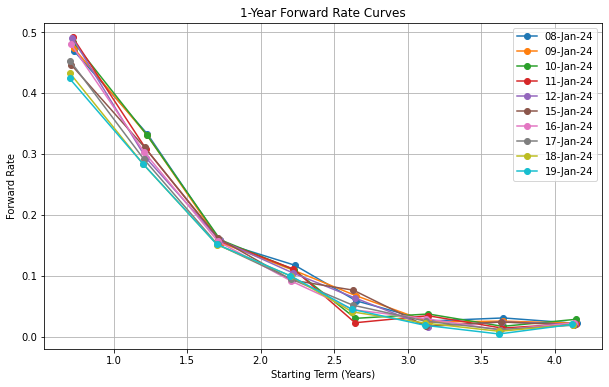

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def calculate_forward_rate(spot_rate1, spot_rate2, term1, term2):
    #Calculate the forward rate from two spot rates
    return -(np.log(spot_rate2) - np.log(spot_rate1)) / (term2 - term1)

# Calculate the forward curve
def calculate_forward_curve(spot_rates):
    terms = sorted(spot_rates.keys())
    forward_rates = {}
    for i in range(1, len(terms) - 1):
        # Calculate the 1-year forward rate starting from each term
        term1 = terms[i]  
        term2 = terms[i + 1]
        spot_rate1 = spot_rates[term1]
        spot_rate2 = spot_rates[term2]
        forward_rate = calculate_forward_rate(spot_rate1, spot_rate2, term1, term2)
        forward_rates[(term1, term2)] = forward_rate
    return forward_rates

# Calculate the forward curves for each date
forward_curves_by_date = {}
for date, spot_rates in spot_rates_by_date.items():
    forward_curve = calculate_forward_curve(spot_rates)
    forward_curves_by_date[date] = forward_curve

# Plotting the forward curves
plt.figure(figsize=(10, 6))
for date, forward_curve in forward_curves_by_date.items():
    terms = [t[0] for t in sorted(forward_curve.keys())]
    rates = [forward_curve[t] for t in sorted(forward_curve.keys())]
    plt.plot(terms, rates, marker='o', label=date.strftime('%d-%b-%y'))

plt.title('1-Year Forward Rate Curves')
plt.xlabel('Starting Term (Years)')
plt.ylabel('Forward Rate')
plt.legend()
plt.grid(True)
plt.show()

## Forward rate data

In [24]:
forward_rates_df = pd.DataFrame.from_dict(forward_curves_by_date, orient='index').sort_index()

# Transpose the dataframe so that terms are rows and dates are columns
forward_rates_df = forward_rates_df.T

# Perform linear interpolation across each row
forward_rates_interpolated = forward_rates_df.interpolate(method='linear', axis=0)

# Forward fill and backward fill to handle NaNs
forward_rates_interpolated.ffill(axis=0, inplace=True)
forward_rates_interpolated.bfill(axis=0, inplace=True)

print(forward_rates_interpolated)

                   2024-01-08  2024-01-09  2024-01-10  2024-01-11  2024-01-12  \
0.731507 1.230137    0.468890    0.473865    0.483985    0.490943    0.490156   
1.230137 1.731507    0.332716    0.473865    0.483985    0.490943    0.490156   
1.731507 2.230137    0.154992    0.473865    0.483985    0.490943    0.490156   
2.230137 2.649315    0.117563    0.473865    0.483985    0.490943    0.490156   
2.649315 3.145205    0.058959    0.473865    0.483985    0.490943    0.490156   
...                       ...         ...         ...         ...         ...   
2.200000 2.619178    0.021971    0.022240    0.028697    0.021696    0.020538   
2.619178 3.115068    0.021971    0.022240    0.028697    0.021696    0.020538   
3.115068 3.619178    0.021971    0.022240    0.028697    0.021696    0.020538   
3.619178 4.117808    0.021971    0.022240    0.028697    0.021696    0.020538   
4.117808 4.621918    0.021971    0.022240    0.028697    0.021696    0.020538   

                   2024-01-

# Q5 - Covariance Matrix

## Covariance Matrix of Yield

In [15]:
def calculate_log_returns_yield(dataframe):
    log_returns = np.log1p(dataframe.pct_change())
    return log_returns

# Calculate the log-returns for the yield curve data
log_returns = calculate_log_returns_yield(yield_curve_data)

# Drop the first row of NaN values
log_returns = log_returns.dropna()

# Covariance matrix 
covariance_matrix_yield = log_returns.cov()

print("Covariance Matrix for the Time Series of Daily Log-Returns of Yield:")
print(covariance_matrix_yield)

Covariance Matrix for the Time Series of Daily Log-Returns of Yield:
            2024-01-08  2024-01-09  2024-01-10  2024-01-11  2024-01-12  \
2024-01-08    0.000015    0.000015    0.000015    0.000016    0.000015   
2024-01-09    0.000015    0.000015    0.000015    0.000016    0.000016   
2024-01-10    0.000015    0.000015    0.000015    0.000016    0.000016   
2024-01-11    0.000016    0.000016    0.000016    0.000018    0.000017   
2024-01-12    0.000015    0.000016    0.000016    0.000017    0.000017   
2024-01-15    0.000014    0.000014    0.000014    0.000015    0.000015   
2024-01-16    0.000014    0.000014    0.000015    0.000016    0.000016   
2024-01-17    0.000014    0.000014    0.000015    0.000016    0.000016   
2024-01-18    0.000015    0.000015    0.000016    0.000018    0.000017   
2024-01-19    0.000015    0.000016    0.000016    0.000018    0.000017   

            2024-01-15  2024-01-16  2024-01-17  2024-01-18  2024-01-19  
2024-01-08    0.000014    0.000014    0.000

## Covariance Matrix of Forward Rate

In [32]:
def calculate_log_returns_forward(dataframe):
    log_returns = np.log1p(dataframe.pct_change())
    return log_returns


log_returns_forward = calculate_log_returns_forward(forward_rates_interpolated)


log_returns_forward = log_returns_forward.dropna()

covariance_matrix_forward = log_returns_forward.cov()

print("Covariance Matrix for the Time Series of Daily Log-Returns of Forward Rates:")
print(covariance_matrix_forward)


Covariance Matrix for the Time Series of Daily Log-Returns of Forward Rates:
            2024-01-08  2024-01-09  2024-01-10  2024-01-11  2024-01-12  \
2024-01-08    0.025072   -0.001519   -0.001403   -0.001549   -0.001576   
2024-01-09   -0.001519    0.026030   -0.001403   -0.001548   -0.001575   
2024-01-10   -0.001403   -0.001403    0.042367   -0.001430   -0.001455   
2024-01-11   -0.001549   -0.001548   -0.001430    0.054696   -0.001606   
2024-01-12   -0.001576   -0.001575   -0.001455   -0.001606    0.036781   
2024-01-15   -0.001564   -0.001563   -0.001443   -0.001593   -0.001621   
2024-01-16   -0.001513   -0.001512   -0.001397   -0.001542   -0.001568   
2024-01-17   -0.001576   -0.001575   -0.001455   -0.001606   -0.001634   
2024-01-18   -0.001525   -0.001525   -0.001408   -0.001555   -0.001581   
2024-01-19   -0.001507   -0.001506   -0.001391   -0.001535   -0.001562   

            2024-01-15  2024-01-16  2024-01-17  2024-01-18  2024-01-19  
2024-01-08   -0.001564   -0.001513 

In [36]:
covariance_matrix_yield.to_csv('covariance_matrix_yield.csv')
covariance_matrix_forward.to_csv('covariance_matrix_forward.csv')

# Q6 - Egienvalue and Eigenvector

In [35]:
covariance_matrix__forward_numpy = covariance_matrix_forward.values


eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix__forward_numpy)


print("Eigenvalues of Forward Covariance Matrix:", eigenvalues)
print("Eigenvectors of Forward Covariance Matrix:", eigenvectors)

Eigenvalues of Forward Covariance Matrix: [0.0792938  0.02004019 0.05532958 0.02707317 0.03042154 0.03580509
 0.03898889 0.04116282 0.04280381 0.04351848]
Eigenvectors of Forward Covariance Matrix: [[-0.02091508  0.61758882 -0.03183398  0.70007171 -0.30453572  0.17420948
   0.0292356  -0.05125662 -0.01996218  0.00783661]
 [-0.0212899   0.53867873 -0.03291139 -0.70816557 -0.40561422  0.19426992
   0.03166087 -0.05482529 -0.02120136  0.00830112]
 [-0.02855561  0.15812866 -0.07237869 -0.01872785  0.08129563 -0.18855114
  -0.07158354  0.27580636  0.34794133 -0.85098383]
 [-0.04880125  0.11381274  0.98606523 -0.01174598  0.04596736 -0.07990443
  -0.0213669   0.05036432  0.02448222 -0.01059693]
 [-0.02794844  0.22827229 -0.05605847 -0.03075968  0.15121892 -0.63750291
   0.65409439 -0.2816725  -0.07642189  0.02693767]
 [-0.03059655  0.1874521  -0.07189216 -0.02281953  0.10145917 -0.25642392
  -0.11456991  0.7115623  -0.59271851  0.10689597]
 [-0.02755484  0.20719301 -0.05744498 -0.02700227  0

In [34]:
covariance_matrix_yield_numpy = covariance_matrix_yield.values


eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix_yield_numpy)


print("Eigenvalues of Yield Covariance Matrix:", eigenvalues)
print("Eigenvectors of Yield Covariance Matrix:", eigenvectors)

Eigenvalues of Yield Covariance Matrix: [1.55648031e-04 2.43702153e-06 7.09162181e-07 3.67390367e-07
 8.48380164e-08 2.65060214e-08 6.99299472e-09 4.86231063e-10
 1.35689707e-11 5.18224669e-12]
Eigenvectors of Yield Covariance Matrix: [[-0.30125935  0.39157983 -0.0977923   0.39033722 -0.39193438 -0.19190953
  -0.16754806  0.28667874 -0.39937364 -0.3657641 ]
 [-0.30339589  0.24956719 -0.19180689  0.16172231 -0.22932991  0.74704597
  -0.03152708 -0.34429994  0.16866752  0.15513908]
 [-0.3115725   0.17490031  0.49546925  0.36395887  0.16519584 -0.08837671
   0.52808171  0.14337681  0.39979956  0.0031009 ]
 [-0.33616848 -0.23235285  0.49728864  0.02071721 -0.29059559 -0.21849229
  -0.42702827 -0.21318004 -0.0868292   0.4666421 ]
 [-0.3297229  -0.03305186 -0.11757603 -0.64918999 -0.50510486 -0.10999726
   0.39912523  0.12999367  0.10495422 -0.02176273]
 [-0.29681348  0.47294444 -0.40531193 -0.10663893  0.38021133 -0.43697203
  -0.06441978 -0.22675262  0.07123357  0.34121783]
 [-0.30227543  